In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1)

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
def draw_linear(
    x: np.ndarray, 
    y_actual: np.ndarray,
    w_actual: np.ndarray,
    y_predict: np.ndarray = None,
    w_predicted: np.ndarray = None
):
  linear_grid = np.linspace(x.min(), x.max(), 100)
  
  if y_predict is not None:
    plt.scatter(x, y_predict, label="predict")
  
  if w_predicted is not None:
    plt.plot(linear_grid, linear_grid * w_predicted[0] + w_predicted[1], label="predicted linear")
    
  plt.scatter(x, y_actual, label="true")
  plt.plot(linear_grid, linear_grid * w_actual[0] + w_actual[1], label="actual linear")

  plt.title("Dependecies")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend()

In [38]:
n_samples = 1024 * 4
n_features = 1
n_targets = 1

In [39]:
bias_actual = 32.
noise = 64

In [40]:
X, Y, coeff_actual = make_regression(
  n_samples=n_samples,
  n_features=n_features,
  n_informative=n_features, 
  n_targets=n_targets,
  coef=True,
  bias=bias_actual,
  noise=noise, random_state=42
)
coeff_actual = [coeff_actual.tolist()] if coeff_actual.shape == () else coeff_actual

Y = Y.reshape((Y.shape[0], 1))

In [41]:
X.shape, Y.shape

((4096, 1), (4096, 1))

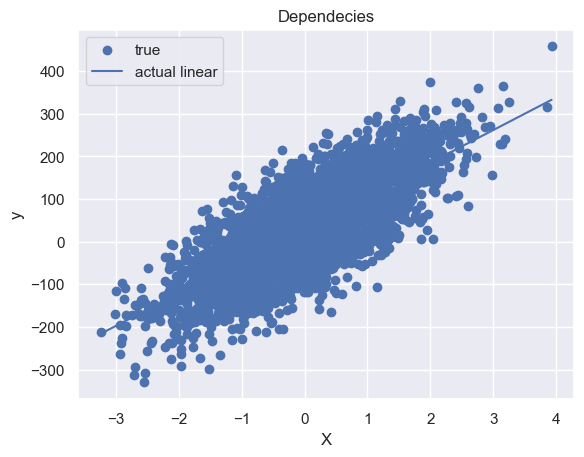

In [42]:
if n_features == 1 and n_targets == 1:
  draw_linear(X, Y, np.array([*coeff_actual, bias_actual]))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=42
)

In [44]:
n_clients = 50

In [45]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from common.distributor import UniformDataDistributor, HomogenousDataDistributorComplex
from optimization.federative.fedavg import FederatedAveraging, Model
from optimization.federative.scaffold import Scaffold

In [47]:
from common.function import MSERidgeLinear, MSELassoLinear

In [48]:
distributor = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=n_clients,
  iid_fraction=0.7
)
mse = MSERidgeLinear(n_features=n_features)
model = Model(mse, distributor, save_history=True)

In [49]:
len(model.server.history), len(model.clients[0].history)

(0, 0)

In [50]:
model.clients.shape

(50,)

In [51]:
from common.pipeline import Pipeline


For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 32, 'eta': 0.0001}:
mse : 5900.515435266772
mae : 61.942583694844394
mape : 1.9975123645059987

For parameters: {'clients_fraction': 0.1, 'batch_size': 64, 'epochs': 128, 'eta': 0.0001}:
mse : 4608.321699827076
mae : 54.730145965424995
mape : 2.5511981211250587
done


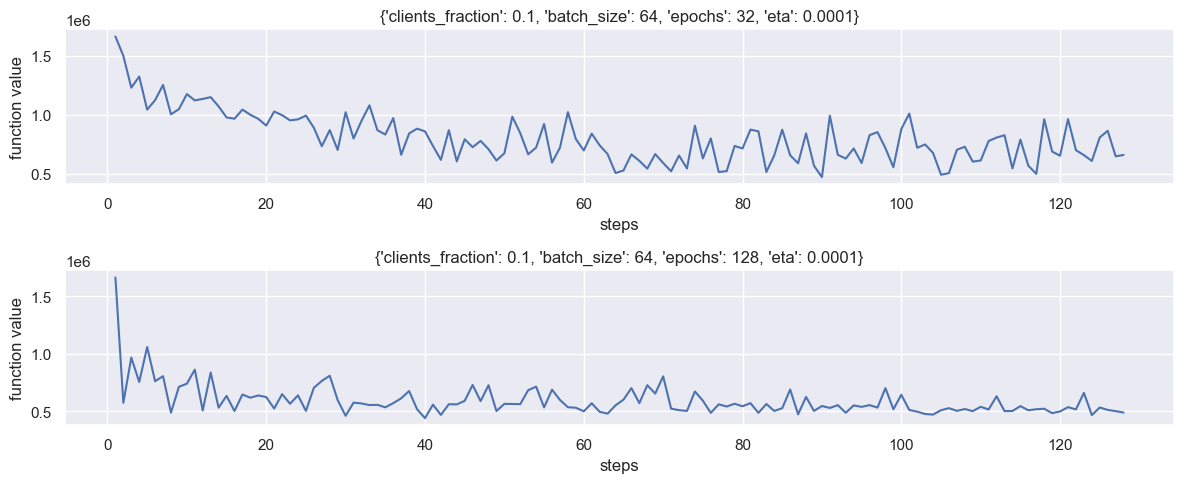

In [54]:
parameters = {
  "clients_fraction": [0.1],
  "batch_size": [64],
  "epochs": [32, 128],
  "rounds": [128],
  "eta": [1e-4],
}
metrics = {
  "mse" : mean_squared_error, 
  "mae" : mean_absolute_error, 
  "mape" : mean_absolute_percentage_error
}

pipeline = Pipeline(
  model=model,
  optimizer=Scaffold,
  parameters=parameters,
  metrics=metrics,
  X_val=X_test,
  y_val=y_test
)

best, best_params = pipeline.run(
  choose_best_by="mae",
  show_global_history=True
)
print("done")

In [147]:
[print(client.function.weights()) for client in best.clients]
best.server.function.weights()

[[53.74164011]
 [12.5297012 ]]
[[57.99199897]
 [11.25036363]]
[[41.29373522]
 [ 4.77371348]]
[[48.61177501]
 [22.72544623]]
[[31.27464657]
 [23.88205486]]
[[49.53259653]
 [25.78079668]]
[[42.58093873]
 [38.43195716]]
[[34.71229769]
 [52.57054893]]
[[19.02653359]
 [65.97674368]]
[[36.89823578]
 [86.28200696]]


array([[49.53259653],
       [25.78079668]])

In [64]:
best_params

{'clients_fraction': 0.1,
 'batch_size': 16,
 'epochs': 32,
 'rounds': 64,
 'eta': 0.001}

  MSE: 16816.93280708874
  MAE: 104.8860088973286
  MAPE: 2.51062291110345


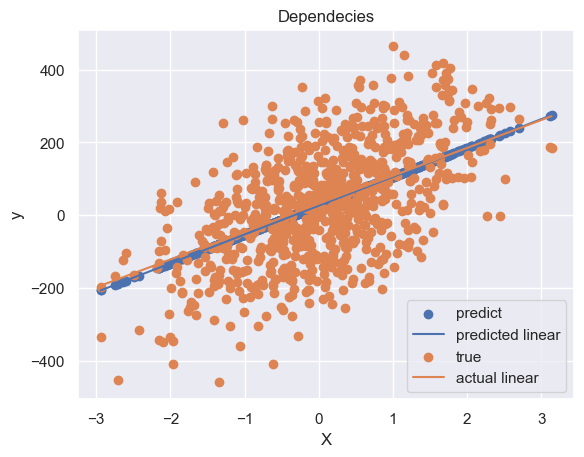

In [190]:
if n_features == 1 and n_targets == 1:
  draw_linear(
    X_test, y_test, np.array([*coeff_actual, bias_actual]),
    best.predict(X_test), best.weights()
  )
print(f"\
  MSE: {mean_squared_error(y_test, best.predict(X_test))}\n\
  MAE: {mean_absolute_error(y_test, best.predict(X_test))}\n\
  MAPE: {mean_absolute_percentage_error(y_test, best.predict(X_test))}\
")

In [ ]:
dict({str({str([1, 2]) : 2}) : 1})

{"{'[1, 2]': 2}": 1}

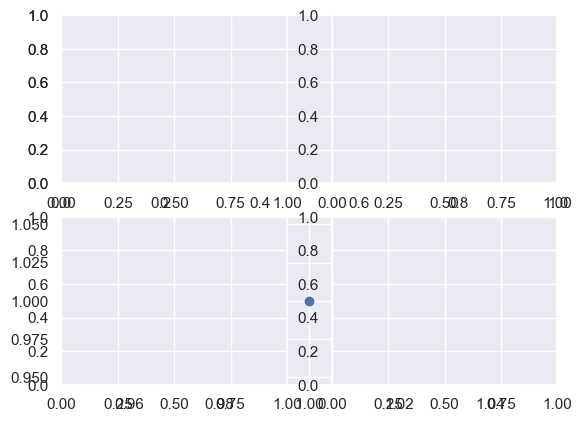

In [ ]:
fig, axes = plt.subplots(2, 1)
subfig, subaxes = fig.subplots(2, 2)
axes[1].scatter([1], [1])

In [26]:
a = np.arange(1, 2 * 10 + 1)
np.random.shuffle(a)
a = a.reshape((10, 2))
a

array([[ 6, 18],
       [19,  8],
       [11, 20],
       [10, 14],
       [ 4,  5],
       [ 2,  3],
       [ 9,  1],
       [17, 16],
       [12, 15],
       [13,  7]])

In [27]:
def by_order(a):
  return np.linalg.norm(a, ord=2, axis=1)

In [28]:
order = np.argsort(by_order(a))

In [29]:
np.take_along_axis(a, order, axis=0)

ValueError: `indices` and `arr` must have the same number of dimensions

In [103]:
def myfn(x):
    return np.linalg.norm(x, ord=2, axis=1)

In [104]:
a = np.abs(np.ceil(np.random.randn(10, 2) * 10))
a

array([[16., 19.],
       [15., 11.],
       [10.,  1.],
       [ 8.,  2.],
       [26., 23.],
       [ 1., 11.],
       [15., 16.],
       [ 6.,  0.],
       [ 4., 15.],
       [31.,  5.]])

In [105]:
predicate = myfn(a)  # not sure if predicate is the best name for this variable
predicate, predicate.shape

(array([24.8394847 , 18.60107524, 10.04987562,  8.24621125, 34.71310992,
        11.04536102, 21.9317122 ,  6.        , 15.5241747 , 31.40063694]),
 (10,))

In [106]:
order = np.argsort(predicate)
order

array([7, 3, 2, 5, 8, 1, 6, 0, 9, 4])

In [107]:
chosen = np.random.choice(order, 2, replace=False)
chosen, a[chosen]

(array([9, 3]),
 array([[31.,  5.],
        [ 8.,  2.]]))

In [108]:
chosen

array([9, 3])

In [109]:
order

array([7, 3, 2, 5, 8, 1, 6, 0, 9, 4])

In [110]:
order = np.delete(order, np.argwhere(np.isin(order, chosen) == True).T[0])

In [111]:
order

array([7, 2, 5, 8, 1, 6, 0, 4])

In [112]:
np.vstack((a[chosen], a[order[:2]]))

array([[31.,  5.],
       [ 8.,  2.],
       [ 6.,  0.],
       [10.,  1.]])

In [113]:
np.delete(order, range(2))

array([5, 8, 1, 6, 0, 4])

In [51]:
np.linalg.norm(a_sorted, ord=2, axis=1)

array([32.06243908, 30.24896692])

In [238]:
distrotest = HomogenousDataDistributor(
  np.arange(0, 60 * 4).reshape((60, 4)),
  np.arange(0, 60).reshape((60, 1)),
  5
)

In [244]:
x[:, 0] // 4 == y[:, 0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [257]:
def _by_norm2(data: np.ndarray):
  return np.linalg.norm(data, ord=2, axis=1)

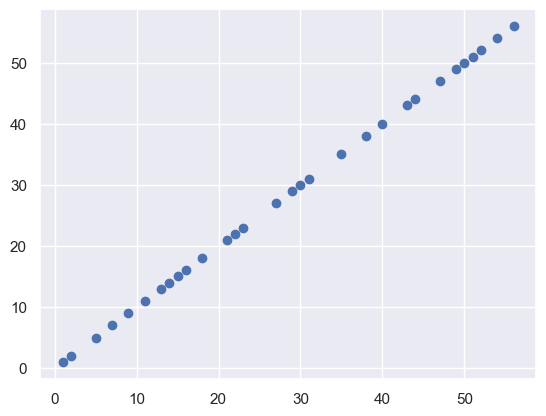

In [276]:
iid_fraction = 0.5
n_samples = 60

def _iid_size(total: int):
  return int(iid_fraction * total)

X = np.arange(0, n_samples).reshape((n_samples, 1))
y = np.arange(0, n_samples).reshape((n_samples, 1))

indices = np.arange(0, n_samples)
np.random.shuffle(indices)

iid = indices[:_iid_size(len(indices))]
X_iid = X[iid]
y_iid = y[iid]

plt.scatter(X_iid, y_iid)

In [277]:
non_iid = indices[_iid_size(len(indices)):]

y_non_iid = y[non_iid]
X_non_iid = X[non_iid]
sorted_non_iid = np.argsort(_by_norm2(y_non_iid))

y_non_iid = y_non_iid[sorted_non_iid]
X_non_iid = X_non_iid[sorted_non_iid]

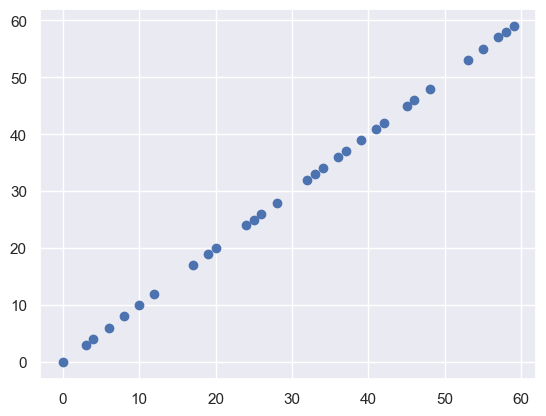

In [279]:
X_non_iid = X[non_iid]
y_non_iid = y[non_iid]
plt.scatter(X_non_iid, y_non_iid)

In [381]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [382]:
from common.distributor import (
  UniformDataDistributor, HomogenousDataDistributor, HomogenousDataDistributorComplex
)
from optimization.federative.fedavg import FederatedAveraging
from optimization.federative.scaffold import Scaffold

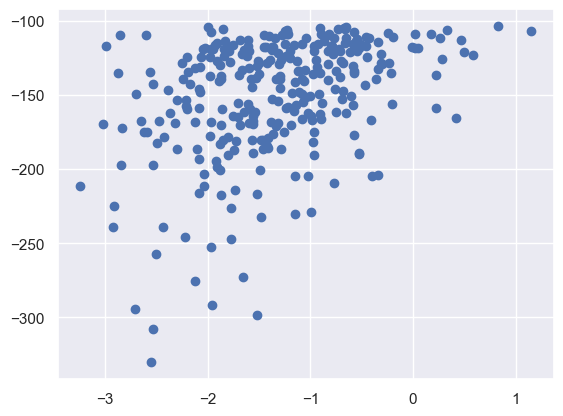

In [388]:
distrotest = HomogenousDataDistributorComplex(
  X=X_train,
  y=y_train,
  n_parts=10,
  iid_fraction=0
)
x, y = distrotest.server_portion()
plt.scatter(x, y)

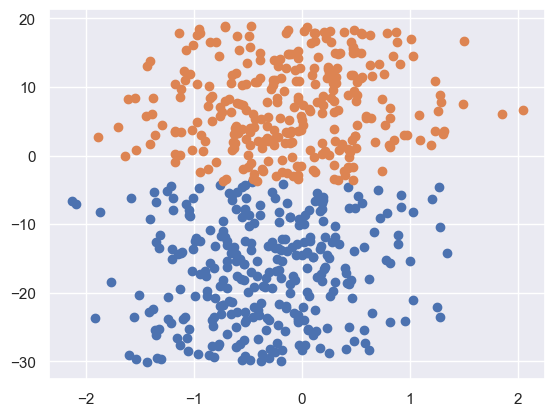

In [389]:
k = 0
for x, y in distrotest.clients_portions():
  if k == 2 or k == 3:
    plt.scatter(x, y)
  k += 1
